In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas_datareader.data as web
from scipy.stats import norm
from sklearn.decomposition import PCA
from datetime import datetime

In [2]:
RISK_FREE_RATE = 0.02 / 252  # Daily risk-free rate (2% annualized)
CONFIDENCE_LEVEL = 0.95
BENCHMARK_TICKER = "^GSPC"

def market_cap(market_cap):
    if market_cap >= 10e9:
        return "Large Cap"
    elif 2e9 <= market_cap < 10e9:
        return "Mid Cap"
    elif  0 <= market_cap < 2e9:
        return "Small Cap"
    else:
        return None
    
def get_stock_details(ticker_str):
    t = yf.Ticker(ticker_str)
    info = t.info
    return {
        'ticker': ticker_str,
        'sector': info.get('sector'),
        'industry': info.get('industry'),
        'market_cap': info.get('marketCap'),
        'cap_class': market_cap(info.get('marketCap'))
    }

def calculate_risk_metrics(returns, weights, benchmark_returns, risk_free_rate=RISK_FREE_RATE, confidence_level=CONFIDENCE_LEVEL):
    portfolio_returns = (returns * weights).sum(axis=1)
    volatility = portfolio_returns.std() * np.sqrt(252)
    beta = portfolio_returns.cov(benchmark_returns) / benchmark_returns.var()
    var = portfolio_returns.quantile(1 - confidence_level)
    cvar = portfolio_returns[portfolio_returns <= var].mean()
    sharpe = ((portfolio_returns.mean() - risk_free_rate) * 252) / volatility
    return {
        "volatility": volatility,
        "beta": beta,
        "VaR": var,
        "CVaR": cvar,
        "sharpe_ratio": sharpe
    }

def build_risk_table(tickers, weights, returns, benchmark_returns, risk_free_rate=RISK_FREE_RATE, confidence_level=CONFIDENCE_LEVEL):
    metrics = []
    for i, ticker in enumerate(tickers):
        asset_returns = returns[ticker]
        asset_metrics = calculate_risk_metrics(
            returns=pd.DataFrame({ticker: asset_returns}),
            weights=np.array([1.0]),
            benchmark_returns=benchmark_returns,
            risk_free_rate=risk_free_rate,
            confidence_level=confidence_level
        )
        metrics.append({
            "ticker": ticker,
            "weight": weights[i],
            "volatility": asset_metrics["volatility"],
            "beta": asset_metrics["beta"],
            "VaR_95": asset_metrics["VaR"],
            "CVaR_95": asset_metrics["CVaR"],
            "Sharpe": asset_metrics["sharpe_ratio"]
        })
    # Portfolio metrics
    port_metrics = calculate_risk_metrics(
        returns=returns,
        weights=weights,
        benchmark_returns=benchmark_returns,
        risk_free_rate=risk_free_rate,
        confidence_level=confidence_level
    )
    metrics.append({
        "ticker": "TOTAL PORTFOLIO",
        "weight": 1.0,
        "volatility": port_metrics["volatility"],
        "beta": port_metrics["beta"],
        "VaR_95": port_metrics["VaR"],
        "CVaR_95": port_metrics["CVaR"],
        "Sharpe": port_metrics["sharpe_ratio"]
    })
    return pd.DataFrame(metrics).round(4)

## Portfolio Summary

### Stock Level Details

In [ ]:
# Define sample portfolio and candidates
trade_log = [
    {"ticker": "TTGT", "date": "2023-01-10", "shares": 50},
    {"ticker": "TTGT", "date": "2023-05-15", "shares": 30},
    {"ticker": "AX", "date": "2023-02-20", "shares": 40},
    {"ticker": "GOOGL", "date": "2023-01-03", "shares": 100},
    {"ticker": "GOOGL", "date": "2023-06-10", "shares": 50},
    {"ticker": "STAG", "date": "2023-03-01", "shares": 70},
    {"ticker": "TALO", "date": "2023-01-18", "shares": 90},
    {"ticker": "TALO", "date": "2023-09-05", "shares": 60},
]


# Step 1: Create DataFrame from trade log
df_trades = pd.DataFrame(trade_log)
df_trades['date'] = pd.to_datetime(df_trades['date'])

# Step 2: Calculate cumulative holdings per ticker
holdings = df_trades.groupby("ticker")["shares"].sum().reset_index()
holdings.columns = ["ticker", "total_shares"]

# Step 3: Get historical data to calculate cost basis and fetch today's price
tickers = holdings["ticker"].tolist()
start_date = df_trades["date"].min().strftime('%Y-%m-%d')
today = datetime.today().strftime('%Y-%m-%d')

# Download closing prices
price_data = yf.download(tickers, start=start_date, end=today)["Close"].ffill()

# Step 4: Calculate weighted average purchase price per stock
costs = {}
for ticker in tickers:
    trades = df_trades[df_trades["ticker"] == ticker]
    prices = price_data[ticker]
    weighted_total = 0
    total_shares = 0
    for _, row in trades.iterrows():
        trade_price = prices.loc[prices.index >= row["date"]].iloc[0]
        weighted_total += trade_price * row["shares"]
        total_shares += row["shares"]
    costs[ticker] = weighted_total / total_shares

# Step 5: Merge and populate portfolio info
holdings["avg_price"] = holdings["ticker"].map(costs)
holdings["latest_price"] = holdings["ticker"].apply(lambda x: price_data[x].iloc[-1])
holdings["holding_value"] = holdings["total_shares"] * holdings["latest_price"]
holdings["cost_basis"] = holdings["total_shares"] * holdings["avg_price"]
holdings["pnl_%"] = ((holdings["latest_price"] - holdings["avg_price"]) / holdings["avg_price"]) * 100

# Add indiviudal stock details
details = {ticker: get_stock_details(ticker) for ticker in tickers}
details_df = pd.DataFrame.from_dict(details, orient="index")
if "ticker" in details_df.columns:
    details_df = details_df.drop(columns=["ticker"])
details_df.index.name = "ticker"
details_df = details_df.reset_index()
details_df.columns = ["ticker", "sector", "industry", "market_cap", "cap_class"]
holdings = holdings.merge(details_df, on="ticker", how="left")

# Calculate portfolio total value and weights
portfolio_value = holdings["holding_value"].sum()
holdings["weight_%"] = (holdings["holding_value"] / portfolio_value) * 100

# Clean final display
cols = [
    "ticker", "sector", "industry","cap_class",
    "total_shares", "avg_price", "latest_price", "holding_value", 
    "weight_%", "pnl_%"
]

final_df = holdings[cols].sort_values("weight_%", ascending=False).reset_index(drop=True)

summary = {
    "ticker": "TOTAL",
    "sector": "",
    "industry": "",
    "cap_class": "",
    "total_shares": holdings["total_shares"].sum(),
    "avg_price": (holdings["avg_price"] * holdings["total_shares"]).sum() / holdings["total_shares"].sum(),
    "latest_price": (holdings["latest_price"] * holdings["total_shares"]).sum() / holdings["total_shares"].sum(),
    "holding_value": holdings["holding_value"].sum(),
    "weight_%": holdings["weight_%"].sum(),
    "pnl_%": (holdings["pnl_%"] * holdings["holding_value"] / holdings["holding_value"].sum()).sum(),
}

final_df = pd.concat([final_df, pd.DataFrame([summary])], ignore_index=True)

num_cols = ["avg_price", "latest_price", "holding_value", "weight_%", "pnl_%", "total_shares"]
final_df[num_cols] = final_df[num_cols].apply(pd.to_numeric, errors='coerce').round(2)

final_df


### Timeseries of Portfolio Value & Daily % Returns since Inception

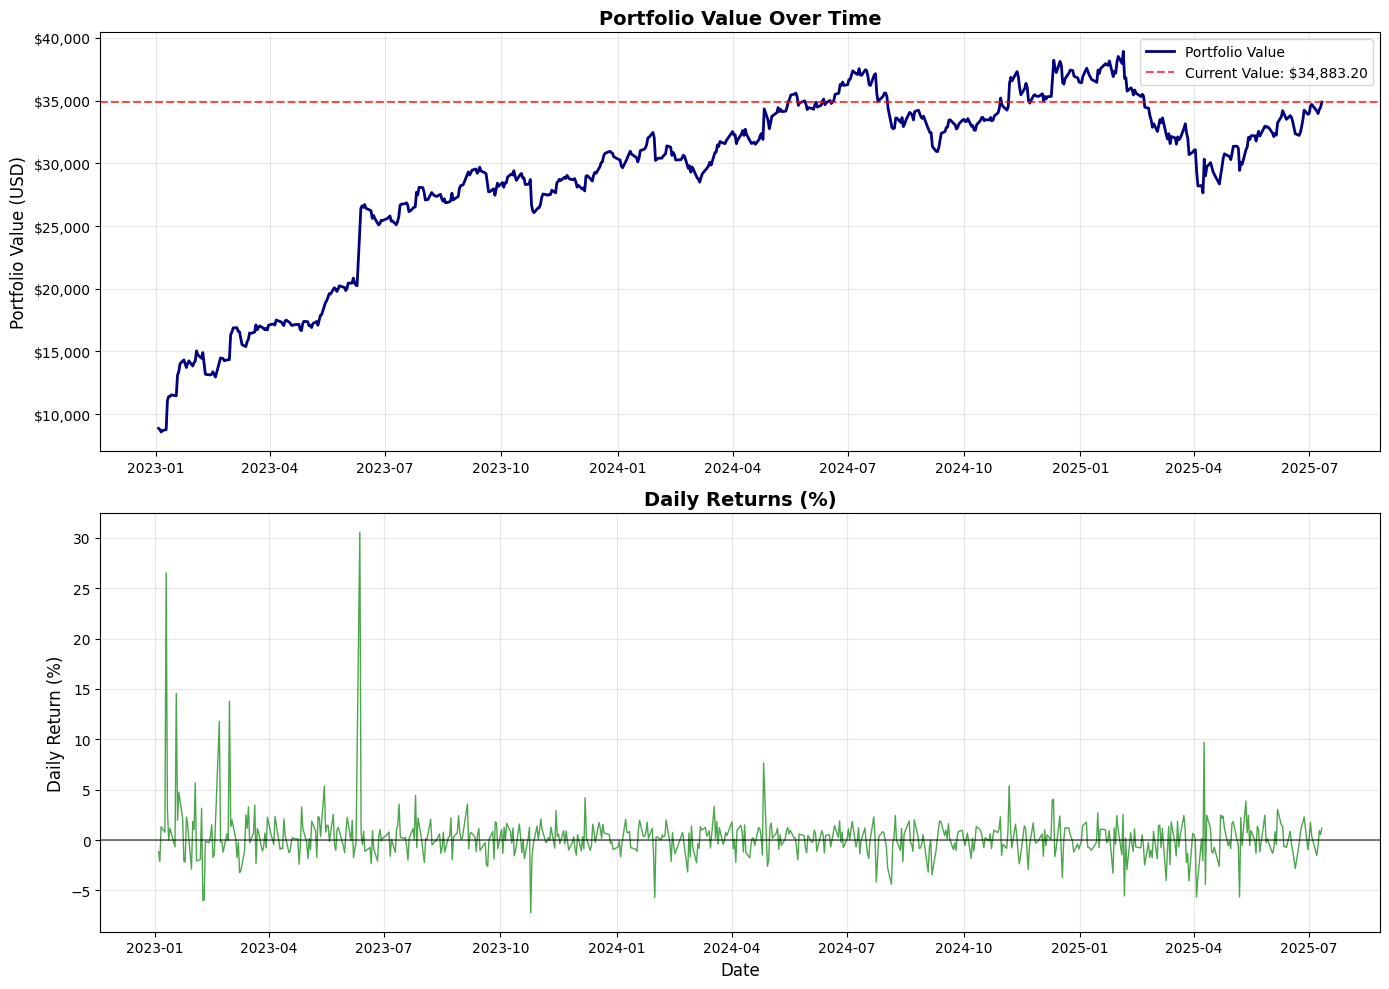


=== PORTFOLIO PERFORMANCE ===
Current Portfolio Value: $34,883.20
Total Return: 293.77%
Annualized Return: 72.72%

=== DAILY RETURN STATISTICS ===
Average Daily Return: 0.246%
Daily Volatility: 2.475%
Best Day: 30.56%
Worst Day: -7.21%


In [4]:
# Build daily portfolio holdings and calculate performance
trading_days = price_data.index

# Create daily holdings DataFrame with proper share tracking
daily_holdings = pd.DataFrame(index=trading_days, columns=tickers, data=0.0)

# Populate daily holdings based on trade dates
for ticker in tickers:
    ticker_trades = df_trades[df_trades['ticker'] == ticker].copy()
    shares_held = 0
    
    for _, trade in ticker_trades.iterrows():
        trade_date = trade['date']
        shares_to_add = trade['shares']
        
        # Find first trading day on or after trade date
        valid_dates = trading_days[trading_days >= trade_date]
        if len(valid_dates) > 0:
            start_date = valid_dates[0]
            shares_held += shares_to_add
            # Update holdings from trade date forward
            daily_holdings.loc[start_date:, ticker] = shares_held

# Calculate daily portfolio value
portfolio_value = (daily_holdings * price_data).sum(axis=1)
portfolio_value = portfolio_value[portfolio_value > 0]  # Remove days with no holdings

# Get current value from table for comparison
current_value = final_df.loc[final_df['ticker'] == 'TOTAL', 'holding_value'].iloc[0]

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Portfolio value over time
ax1.plot(portfolio_value.index, portfolio_value.values, 
         linewidth=2, color='navy', label='Portfolio Value')
ax1.axhline(y=current_value, color='red', linestyle='--', alpha=0.7, 
           label=f'Current Value: ${current_value:,.2f}')
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Daily returns
daily_returns = portfolio_value.pct_change().dropna() * 100
ax2.plot(daily_returns.index, daily_returns.values, 
         linewidth=1, color='green', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_title('Daily Returns (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Daily Return (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance statistics
if len(daily_returns) > 0:
    total_return = ((portfolio_value.iloc[-1] - portfolio_value.iloc[0]) / portfolio_value.iloc[0]) * 100
    annualized_return = ((portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / len(portfolio_value)) - 1) * 100
    
    print(f"\n=== PORTFOLIO PERFORMANCE ===")
    print(f"Current Portfolio Value: ${current_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annualized_return:.2f}%")
    print(f"\n=== DAILY RETURN STATISTICS ===")
    print(f"Average Daily Return: {daily_returns.mean():.3f}%")
    print(f"Daily Volatility: {daily_returns.std():.3f}%")
    print(f"Best Day: {daily_returns.max():.2f}%")
    print(f"Worst Day: {daily_returns.min():.2f}%")
else:
    print("No portfolio data available for analysis.")

## Portfolio Risk Analysis

### Breakdown of Volatility, Beta, Value at Risk, Conditional Value at Risk
* Beta is computed against the S&P
* 95% Confidence Level

In [ ]:
# Download price data including benchmark (S&P)
all_tickers = tickers + [BENCHMARK_TICKER]
prices = yf.download(all_tickers, start=start_date, end=today)['Close'].ffill()

# Calculate daily returns
returns = prices.pct_change().dropna()
individual_returns = returns[tickers]
benchmark_returns = returns[BENCHMARK_TICKER]

# Calculate portfolio weights
weights_df = holdings[['ticker', 'holding_value']].copy()
total_portfolio_value = weights_df['holding_value'].sum()
weights_df['weight'] = weights_df['holding_value'] / total_portfolio_value
weights_dict = dict(zip(weights_df['ticker'], weights_df['weight']))

# Calculate weighted portfolio returns
portfolio_daily_returns = (individual_returns * pd.Series(weights_dict)).sum(axis=1)

# Individual stock risk metrics
volatility = individual_returns.std() * np.sqrt(252)

# Individual beta calculation
beta = []
for ticker in tickers:
    cov = returns[ticker].cov(benchmark_returns)
    var = benchmark_returns.var()
    beta.append(cov / var)
beta = np.array(beta)

# Individual stock VaR and CVaR at 95% confidence
var_95_individual = individual_returns.quantile(1 - CONFIDENCE_LEVEL)
cvar_95_individual = individual_returns[individual_returns <= var_95_individual].mean()

# Portfolio-level risk metrics
portfolio_volatility = portfolio_daily_returns.std() * np.sqrt(252)
portfolio_beta = portfolio_daily_returns.cov(benchmark_returns) / benchmark_returns.var()
portfolio_var_95 = portfolio_daily_returns.quantile(1 - CONFIDENCE_LEVEL)
portfolio_cvar_95 = portfolio_daily_returns[portfolio_daily_returns <= portfolio_var_95].mean()

# Create individual stock risk metrics DataFrame
risk_metrics = pd.DataFrame({
    "ticker": tickers,
    "weight": [weights_dict[ticker] for ticker in tickers],
    "volatility": volatility.values,
    "beta": beta,
    "VaR_95": var_95_individual.values,
    "CVaR_95": cvar_95_individual.values
})

# Add portfolio summary row
portfolio_summary = pd.DataFrame([{
    'ticker': 'TOTAL PORTFOLIO',
    'weight': 1.0,
    'volatility': portfolio_volatility,
    'beta': portfolio_beta,
    'VaR_95': portfolio_var_95,
    'CVaR_95': portfolio_cvar_95
}])

# Combine individual and portfolio metrics
final_risk_metrics = pd.concat([risk_metrics, portfolio_summary], ignore_index=True)

# Clean up display
display_cols = ['ticker', 'weight', 'volatility', 'beta', 'VaR_95', 'CVaR_95']
final_risk_metrics = final_risk_metrics[display_cols].round(4)

print("=== PORTFOLIO RISK METRICS ===")
print(final_risk_metrics)

print(f"\n=== PORTFOLIO VERIFICATION ===")
print(f"Portfolio Annualized Volatility: {portfolio_volatility:.4f}")
print(f"Portfolio Beta vs S&P 500: {portfolio_beta:.4f}")
print(f"Portfolio VaR (95%): {portfolio_var_95:.4f}")
print(f"Portfolio CVaR (95%): {portfolio_cvar_95:.4f}")

#### Visual for each risk metric

In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")
metrics = [
    ("volatility", "Volatility (Annualized Std Dev)", "Annual price fluctuation risk"),
    ("beta", "Beta vs S&P 500", "Sensitivity to market movements"),
    ("VaR_95", "Value at Risk (95%)", "Maximum daily loss with 95% confidence"),
    ("CVaR_95", "Conditional Value at Risk (95%)", "Expected loss if VaR is exceeded"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (col, title, explanation) in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(risk_metrics["ticker"], risk_metrics[col], 
                  color=["#1f77b4" for t in risk_metrics["ticker"]])
    ax.set_title(f"{title}\n({explanation})", fontsize=11)
    ax.set_xlabel("Ticker")
    ax.set_ylabel(col)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xticklabels(risk_metrics["ticker"], rotation=45)

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

### Sector Exposures

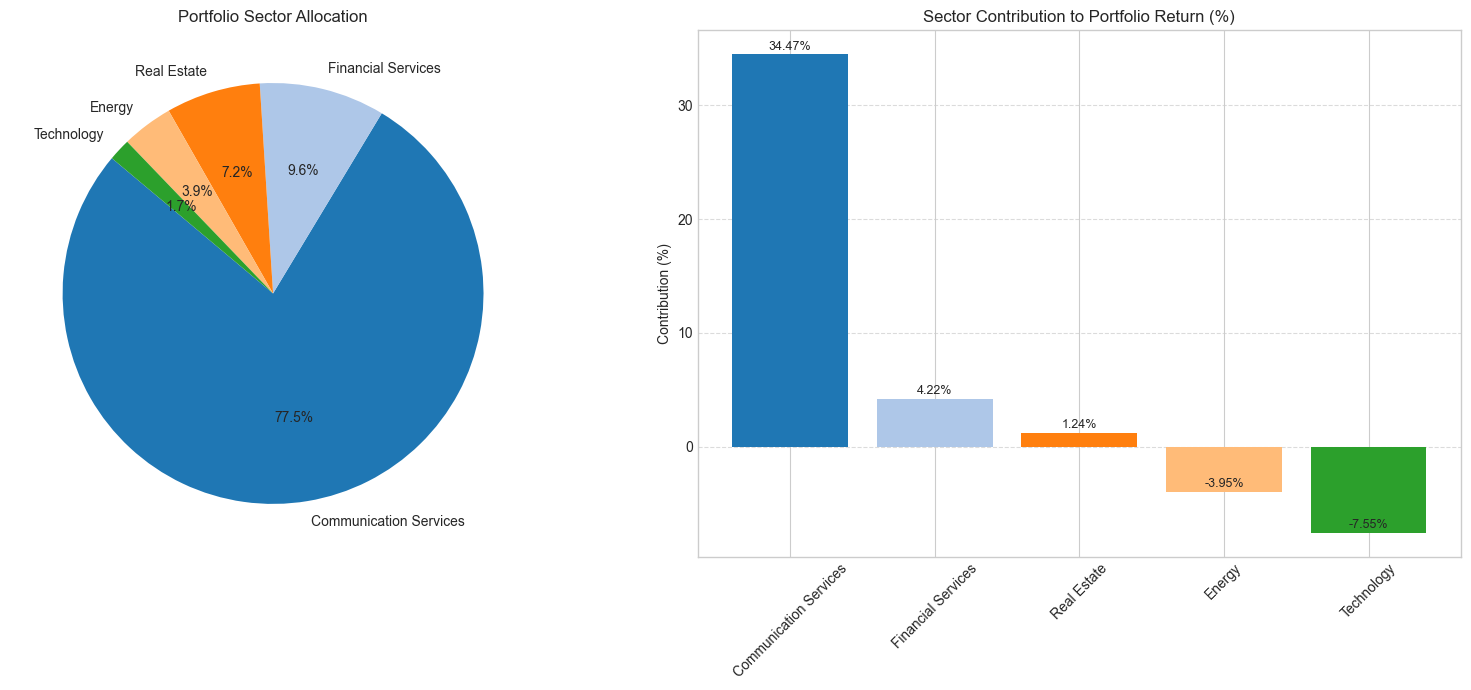

In [7]:
# Calculate sector dollar return
holdings["dollar_return"] = (holdings["latest_price"] - holdings["avg_price"]) * holdings["total_shares"]

sector_group = holdings.groupby("sector").agg({
    "holding_value": "sum",
    "dollar_return": "sum"
})

# Compute sector return and weight
total_portfolio_value = holdings["holding_value"].sum()
sector_group["weight_%"] = sector_group["holding_value"] / total_portfolio_value * 100
sector_group["sector_return_%"] = (sector_group["dollar_return"] / sector_group["holding_value"]) * 100

# Compute contribution to total return
sector_group["contribution_%"] = (sector_group["weight_%"] * sector_group["sector_return_%"]) / 100
sector_group = sector_group.sort_values("contribution_%", ascending=False).round(2)

# Pie chart
sector_exposure_pct = sector_group["weight_%"]
sector_labels = sector_exposure_pct.index.tolist()
colors = plt.cm.tab20.colors[:len(sector_exposure_pct)]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].pie(sector_exposure_pct, labels=sector_labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title("Portfolio Sector Allocation")

# Bar chart: sector contribution to return
bars = axes[1].bar(sector_labels, sector_group["contribution_%"], color=colors)
axes[1].set_title("Sector Contribution to Portfolio Return (%)")
axes[1].set_ylabel("Contribution (%)")
axes[1].set_xticks(range(len(sector_labels)))
axes[1].set_xticklabels(sector_labels, rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Factor Exposure

In [ ]:
# 1. Download Fama-French 5-Factor daily data
ff_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date)[0]
ff_factors.index = ff_factors.index.to_timestamp()
ff_factors = ff_factors / 100  # Convert from % to decimal

# 2. Align factor data to portfolio returns
portfolio_returns = portfolio_daily_returns
common_dates = portfolio_returns.index.intersection(ff_factors.index)
ff_factors = ff_factors.loc[common_dates]
excess_returns = portfolio_returns.loc[common_dates] - ff_factors['RF']

# 3. Prepare factor matrix (X) and run regression for portfolio
X = ff_factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X) 
y = excess_returns

model = sm.OLS(y, X).fit()
portfolio_exposure = model.params

# 4. Visualize portfolio factor exposures
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
exposures = [portfolio_exposure[f] for f in factors]

plt.figure(figsize=(10, 6))
bars = plt.bar(factors, exposures, color=plt.cm.tab20.colors[:len(factors)])
plt.axhline(0, color='black', linewidth=0.7)
plt.title("Portfolio Factor Exposures", fontsize=14, fontweight='bold')
plt.ylabel("Sensitivity (Beta)")

# Add annotations
for bar, val, factor in zip(bars, exposures, factors):
    color = 'green' if val > 0 else 'red'
    plt.annotate(f"{val:.3f}", xy=(bar.get_x() + bar.get_width()/2, val),
                xytext=(0, 5 if val >= 0 else -15), 
                textcoords="offset points", ha='center', fontsize=10,
                color=color)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust for the text at bottom
plt.show()

### Stress Test

             Estimated Return (%)  Estimated PnL ($)
Covid Crash                 -0.03             -12.13
Rate Hike                   -0.26             -90.70
Tech Crash                  -0.61            -213.43


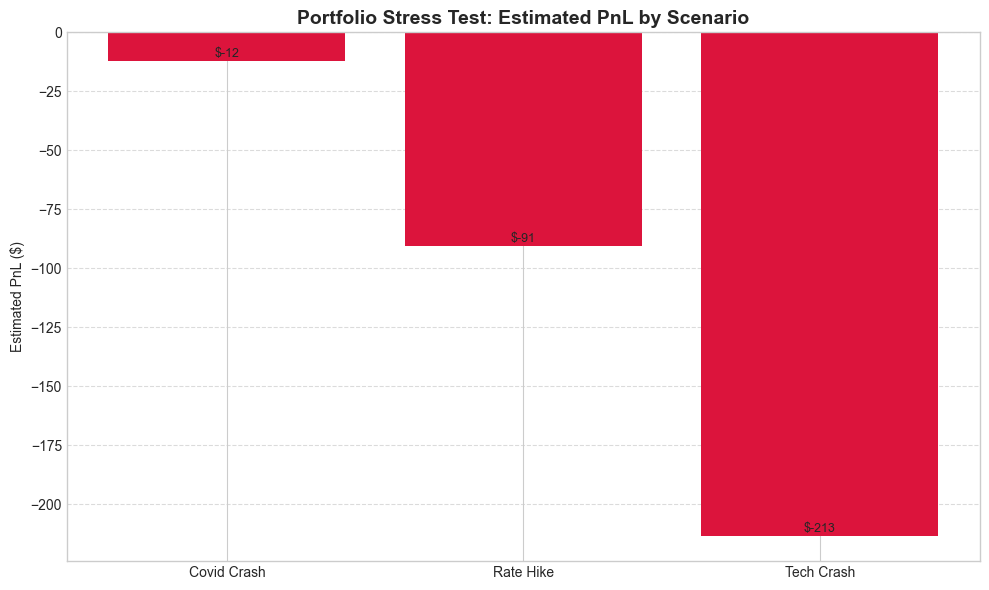

In [9]:
# Define stress scenarios (factor shocks)
stress_scenarios = {
    "Covid Crash": {
        "Mkt-RF": -0.12,   # -12% market
        "SMB": -0.02,
        "HML": -0.03,
        "RMW": -0.01,
        "CMA": -0.01
    },
    "Rate Hike": {
        "Mkt-RF": -0.03,
        "SMB": 0.01,
        "HML": 0.02,
        "RMW": 0.00,
        "CMA": 0.01
    },
    "Tech Crash": {
        "Mkt-RF": -0.08,
        "SMB": 0.02,
        "HML": 0.03,
        "RMW": -0.01,
        "CMA": -0.01
    }
}

# Use portfolio factor exposures from Fama-French regression
factor_betas = portfolio_exposure[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values

stress_results = {}

for scenario_name, shock in stress_scenarios.items():
    shock_vector = np.array([shock[factor] for factor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
    estimated_return = np.dot(factor_betas, shock_vector)  # portfolio return for scenario
    estimated_pnl = estimated_return * current_value       # dollar impact
    
    stress_results[scenario_name] = {
        "Estimated Return (%)": estimated_return * 100,
        "Estimated PnL ($)": estimated_pnl
    }

stress_df = pd.DataFrame(stress_results).T.round(2)
print(stress_df)

# Bar chart for PnL
plt.figure(figsize=(10,6))
bars = plt.bar(stress_df.index, stress_df["Estimated PnL ($)"], color='crimson')
plt.title("Portfolio Stress Test: Estimated PnL by Scenario", fontsize=14, fontweight='bold')
plt.ylabel("Estimated PnL ($)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"${height:,.0f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### How potential candidate stocks can affect current portfolio risk 

In [ ]:
# Example candidate stocks
candidates = [
    {"ticker": "MSFT", "shares": 50},
    {"ticker": "XOM", "shares": 60},
    {"ticker": "NVO", "shares": 40},
]
df_candidates = pd.DataFrame(candidates)

candidate_tickers = df_candidates["ticker"].tolist()

# Fetch historical prices
candidate_prices = yf.download(candidate_tickers, start=start_date, end=today)["Close"].ffill()

# Calculate current price (latest row)
latest_prices = candidate_prices.iloc[-1]

# Add latest price and market value
df_candidates["latest_price"] = df_candidates["ticker"].map(latest_prices)
df_candidates["holding_value"] = df_candidates["shares"] * df_candidates["latest_price"]

# Fetch factor exposures for candidates
candidate_details = {ticker: get_stock_details(ticker) for ticker in candidate_tickers}
candidate_factors = {}

# Align factor dates
candi_dates = candidate_prices.index.intersection(ff_factors.index)
ff_factors_candi = ff_factors.loc[candi_dates]
excess_returns_candi = candidate_prices.loc[candi_dates].subtract(ff_factors_candi['RF'], axis=0)

X_candi = ff_factors_candi[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X_candi = sm.add_constant(X_candi)

for ticker in candidate_tickers:
    y = excess_returns_candi[ticker]
    model = sm.OLS(y, X_candi).fit()
    candidate_factors[ticker] = model.params

candidate_factor_df = pd.DataFrame(candidate_factors).T.drop(columns="const")
candidate_factor_df["holding_value"] = df_candidates.set_index("ticker")["holding_value"]

# --- Stock-level factor exposures for existing portfolio ---
stock_factors = {}
for ticker in tickers:
    # Align dates for each stock
    stock_dates = prices.index.intersection(ff_factors.index)
    ff_factors_stock = ff_factors.loc[stock_dates]
    excess_returns_stock = prices.loc[stock_dates][ticker] - ff_factors_stock['RF']
    X_stock = ff_factors_stock[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X_stock = sm.add_constant(X_stock)
    y = excess_returns_stock
    model = sm.OLS(y, X_stock).fit()
    stock_factors[ticker] = model.params

factor_betas = pd.DataFrame(stock_factors).T.drop(columns="const")
factor_betas["holding_value"] = holdings.set_index("ticker")["holding_value"]

existing_factors = factor_betas.copy()

# Combine existing and candidate exposures
all_factors = pd.concat([existing_factors, candidate_factor_df])

# Recalculate weights
all_factors["weight"] = all_factors["holding_value"] / all_factors["holding_value"].sum()

# Weighted average exposures
portfolio_with_candidates = (all_factors.drop(columns=["holding_value", "weight"]).T @ all_factors["weight"]).to_dict()

def portfolio_volatility(factor_matrix, weights, cov_matrix):
    beta_port = weights.T @ factor_matrix
    port_var = beta_port @ cov_matrix @ beta_port.T
    return np.sqrt(port_var).item()

# Estimate factor return covariance
factor_cov = X.drop(columns="const").cov()

# Before
original_weights = existing_factors.copy()
original_weights["weight"] = original_weights["holding_value"] / original_weights["holding_value"].sum()
original_weight_vector = original_weights["weight"].values

# After
new_weight_vector = all_factors["weight"].values

# Drop only columns that exist to avoid KeyError
drop_cols_existing = [col for col in ["holding_value", "weight"] if col in existing_factors.columns]
drop_cols_all = [col for col in ["holding_value", "weight"] if col in all_factors.columns]

# Calculate volatilities
vol_before = portfolio_volatility(existing_factors.drop(columns=drop_cols_existing), original_weight_vector, factor_cov)
vol_after = portfolio_volatility(all_factors.drop(columns=drop_cols_all), new_weight_vector, factor_cov)

print(f"Original Portfolio Volatility: {vol_before:.4f}")
print(f"New Portfolio Volatility (with candidates): {vol_after:.4f}")

comparison = pd.DataFrame({
    "Before": (existing_factors.drop(columns=drop_cols_existing).T @ original_weight_vector),
    "After": (all_factors.drop(columns=drop_cols_all).T @ new_weight_vector)
}).round(3)

comparison.plot(kind='bar', figsize=(10,6), color=["#1f77b4", "#ff7f0e"])
plt.title("Factor Exposures: Before vs After Adding Candidates")
plt.ylabel("Beta Exposure")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Comparison before addition of candidate stocks

In [ ]:
# Before: current portfolio only
weights_before = holdings.set_index("ticker")["holding_value"] / holdings["holding_value"].sum()
risk_table_before = build_risk_table(
    tickers,
    weights_before.values,
    individual_returns,
    benchmark_returns
)

print("=== RISK METRICS BEFORE ADDING CANDIDATES ===")
print(risk_table_before)

# After: add candidate stocks
all_holdings = pd.concat([
    holdings[["ticker", "holding_value"]],
    df_candidates[["ticker", "holding_value"]]
], ignore_index=True)
all_tickers = all_holdings["ticker"].tolist()
all_weights = all_holdings.set_index("ticker")["holding_value"] / all_holdings["holding_value"].sum()

# Download prices for all stocks if needed
all_prices = yf.download(all_tickers + [BENCHMARK_TICKER], start=start_date, end=today)["Close"].ffill()
all_returns = all_prices.pct_change().dropna()
all_individual_returns = all_returns[all_tickers]
all_benchmark_returns = all_returns[BENCHMARK_TICKER]

# Calculate risk metrics for combined portfolio
risk_table_after = build_risk_table(
    all_tickers,
    all_weights.values,
    all_individual_returns,
    all_benchmark_returns
)

# Show portfolio summary comparison
portfolio_before = risk_table_before.loc[risk_table_before["ticker"] == "TOTAL PORTFOLIO"]
portfolio_after = risk_table_after.loc[risk_table_after["ticker"] == "TOTAL PORTFOLIO"]

print("\n=== PORTFOLIO RISK COMPARISON ===")
comparison = pd.DataFrame({
    "Metric": ["Volatility", "Beta", "VaR_95", "CVaR_95", "Sharpe"],
    "Before": portfolio_before[["volatility", "beta", "VaR_95", "CVaR_95", "Sharpe"]].values[0],
    "After": portfolio_after[["volatility", "beta", "VaR_95", "CVaR_95", "Sharpe"]].values[0],
    "Change %": ((portfolio_after[["volatility", "beta", "VaR_95", "CVaR_95", "Sharpe"]].values[0] / 
                 portfolio_before[["volatility", "beta", "VaR_95", "CVaR_95", "Sharpe"]].values[0] - 1) * 100)
})
print(comparison.round(4))

print("\n=== RISK METRICS AFTER ADDING CANDIDATES (FULL TABLE) ===")
print(risk_table_after)